In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [ ]:
from clustering.utils import *

# Experiments
To Do: Model specific score with 1 cluster

In [ ]:
restart_experiments = True
n_iterations = 10
methods = ['gmm_full', 'kmeans'] #'gmm_tied', 'gmm_diag', 'gmm_spherical',
list_n_cluster = np.arange(1,8,1)
if restart_experiments:
  random_seeds = np.random.randint(high=200, low=1, size=n_iterations)
else:
  random_seeds = np.array([ 51, 108,  75, 134,  26,  55,  74, 118, 128,  54])
random_seeds

array([ 51, 108,  75, 134,  26,  55,  74, 118, 128,  54])

In [ ]:
#dict_results[Iteration]['Method'][Cluster_number]['Score']
if restart_experiments:
  # Create Empty Dictionary
  dict_results = {}
  for i in np.arange(n_iterations):
    dict_results_iteration = {}
    for method in methods:
      dict_temp = {}
      for n_cluster in list_n_cluster:
        dict_entry = {'silhouette_score': np.nan, 'ch_score': np.nan, 'db_score': np.nan, 'model_specific_score': np.nan}
        dict_temp.update({n_cluster:dict_entry})
      dict_results_iteration.update({method: dict_temp})
    dict_results.update({i:dict_results_iteration})

In [ ]:
if restart_experiments:
  cov_type='full'
  # Experiments
  for i in np.arange(n_iterations):
    random_seed = random_seeds[i]
    for method in methods:
      method_name = method
      if method[:3]=='gmm':
        method_name = method.rsplit('_')[0]
        cov_type = method.rsplit('_')[1]
      for n_cluster in list_n_cluster:
        answers, labels, model_specific_score = get_cluster_data_experiments(n_cluster=n_cluster, method=method_name, cov_type=cov_type, random_seed=random_seed, cluster_input_data='fa_data', start_train='2020-07-31', end_train='2020-12-01')
        dict_results[i][method][n_cluster]['model_specific_score'] = model_specific_score
        if n_cluster > 1:
          dict_results[i][method][n_cluster]['silhouette_score'] = metrics.silhouette_score(answers, labels, metric='euclidean')
          dict_results[i][method][n_cluster]['ch_score'] = metrics.calinski_harabasz_score(answers, labels)
          dict_results[i][method][n_cluster]['db_score'] = metrics.davies_bouldin_score(answers, labels)
        

In [ ]:
if restart_experiments:
  # Transform Dictionary to DataFrame
  df_results = pd.DataFrame(columns=['iteration', 'random_seed', 'method', 'number_cluster', 'silhouette_score', 'ch_score', 'model_specific_score'])
  for i in np.arange(n_iterations):
    for method in methods:
      df_temp = pd.DataFrame.from_dict(dict_results[i][method], orient='index')
      df_temp['iteration'] = i
      df_temp['random_seed'] = random_seeds[i]
      df_temp['number_cluster'] = df_temp.index
      df_temp['method'] = method
      df_results = df_results.append(df_temp)
  df_results.reset_index(inplace=True, drop=True)
  df_results.to_csv('results/clustering/results_clustering_3.csv', index=False)
  df_results.head()

In [ ]:
if restart_experiments:
  df_results_agg = df_results.groupby(['method', 'number_cluster']).mean().reset_index()
  df_results_std = df_results.groupby(['method', 'number_cluster']).std().reset_index()
  avg_col_list = df_results_agg.columns[2:].to_list()
  for element in avg_col_list:
    df_results_agg.rename(columns={element: element+'_avg'}, inplace=True)
    df_results_agg[element + '_std'] = df_results_std[element]
  df_results_agg.to_csv('results/clustering/results_clustering_agg_3.csv', index=False)
  df_results_agg.head()

In [ ]:
if restart_experiments == False:
  df_results = pd.read_csv('results/clustering/results_clustering_2.csv')
  df_results_agg = pd.read_csv('results/clustering/results_clustering_agg_2.csv')

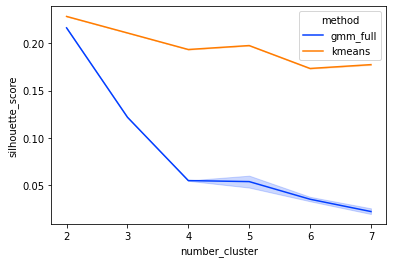

In [ ]:
sns.lineplot(data=df_results, x='number_cluster', y='silhouette_score', hue='method', palette='bright') # Close to 1

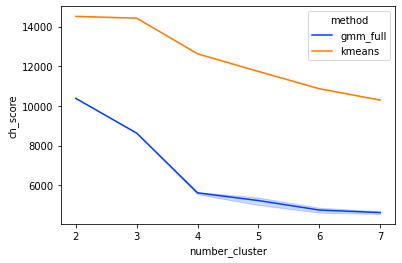

In [ ]:
sns.lineplot(data=df_results, x='number_cluster', y='ch_score', hue='method', palette='bright') # Maximize

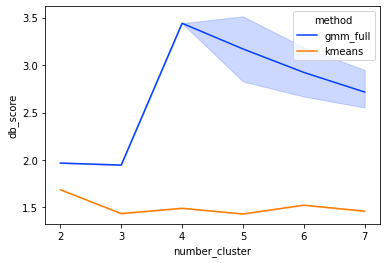

In [ ]:
sns.lineplot(data=df_results, x='number_cluster', y='db_score', hue='method', palette='bright') # close to zero

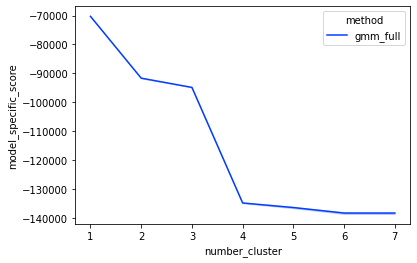

In [ ]:
sns.lineplot(data=df_results[df_results['method']!='kmeans'], x='number_cluster', y='model_specific_score', hue='method', palette='bright') # BIC - Minimize / find elbow

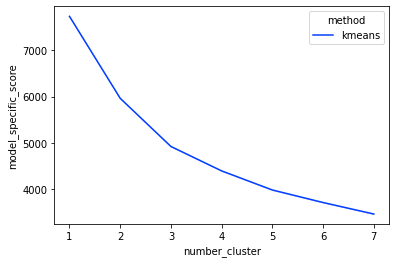

In [ ]:
sns.lineplot(data=df_results[df_results['method']=='kmeans'], x='number_cluster', y='model_specific_score', hue='method', palette='bright') # Find elbow

# Test Rand Score

In [ ]:
#dict_rand_scores[iteration][number_cluster] - avg_rand_score

In [16]:
# Create empty dict
dict_rand_scores = {}
for i in np.arange(n_iterations):
  dict_temp = {}
  for n_cluster in list_n_cluster:
    dict_temp.update({n_cluster: np.nan})
  dict_rand_scores.update({i: dict_temp})
dict_rand_scores

{0: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 1: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 2: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 3: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 4: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 5: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 6: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 7: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 8: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 9: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan}}

In [17]:
# Calc Rand Scores
for i in np.arange(n_iterations):
  random_seed = random_seeds[i]
  for n_cluster in list_n_cluster:
    cum_rand_scores = 0
    for method_1 in methods:
      df_1 = pd.read_csv('data/clustering/experiments/random_seed_' + str(random_seed) + '/' + method_1 +'_' + str(n_cluster) + '.csv')
      labels_1 = df_1['group'].to_numpy()
      for method_2 in methods:
        df_2 = pd.read_csv('data/clustering/experiments/random_seed_' + str(random_seed) + '/' + method_2 +'_' + str(n_cluster) + '.csv')
        labels_2 = df_2['group'].to_numpy()
        rand_score = metrics.adjusted_rand_score(labels_1, labels_2)
        
        #print(str(n_cluster) + ' Cluster - Comparing ' + method_1 + ' with ' + method_2 + ' - Rand Score: ' + str(rand_score))
        cum_rand_scores = cum_rand_scores + rand_score
    avg_rand_score = (cum_rand_scores-len(methods)) / ((len(methods)-1)*len(methods))
    dict_rand_scores[i][n_cluster] = avg_rand_score
    print(str(n_cluster) + ' Cluster with average rand score: ' + str(avg_rand_score))

1 Cluster with average rand score: 1.0
2 Cluster with average rand score: 0.4042181913497309
3 Cluster with average rand score: 0.36806192398463367
4 Cluster with average rand score: 0.1434979826960694
5 Cluster with average rand score: 0.13585625740085128
6 Cluster with average rand score: 0.160620993007617
7 Cluster with average rand score: 0.22470149551700214
1 Cluster with average rand score: 1.0
2 Cluster with average rand score: 0.40641331442232387
3 Cluster with average rand score: 0.36870264419290644
4 Cluster with average rand score: 0.11753832457514535
5 Cluster with average rand score: 0.13420545770507486
6 Cluster with average rand score: 0.14568642584857416
7 Cluster with average rand score: 0.1852358440112125
1 Cluster with average rand score: 1.0
2 Cluster with average rand score: 0.4035626472837248
3 Cluster with average rand score: 0.36874407566273404
4 Cluster with average rand score: 0.14494634165975429
5 Cluster with average rand score: 0.19600268717970337
6 Cluster

In [18]:
# Create DataFrames
df_rand_scores = pd.DataFrame.from_dict(dict_rand_scores)
df_rand_scores['n_cluster'] = df_rand_scores.index
df_rand_scores_plot = pd.melt(df_rand_scores, id_vars='n_cluster')
df_rand_scores_plot.rename(columns={'variable': 'iteration', 'value': 'rand_score'}, inplace=True)
for i in np.arange(n_iterations):
  df_rand_scores.rename(columns={i: 'rand_score_' + str(i)}, inplace=True)
df_rand_scores['avg_rand_score'] = pd.DataFrame.from_dict(dict_rand_scores, orient='index').mean()
df_rand_scores['std_rand_score'] = pd.DataFrame.from_dict(dict_rand_scores, orient='index').std()
df_rand_scores

,rand_score_0,rand_score_1,rand_score_2,rand_score_3,rand_score_4,rand_score_5,rand_score_6,rand_score_7,rand_score_8,rand_score_9,n_cluster,avg_rand_score,std_rand_score
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,0.000000
2,0.404218,0.406413,0.403563,0.405538,0.407028,0.407393,0.404904,0.404162,0.404634,0.405555,2,0.405341,0.001282
3,0.368062,0.368703,0.368744,0.369606,0.369205,0.369610,0.369339,0.368689,0.368743,0.368566,3,0.368927,0.000498
4,0.143498,0.117538,0.144946,0.143496,0.144586,0.144892,0.144480,0.116400,0.145115,0.144123,4,0.138907,0.011579
5,0.135856,0.134205,0.196003,0.196100,0.195405,0.136012,0.195679,0.195109,0.195391,0.196038,5,0.177580,0.029142
6,0.160621,0.145686,0.126195,0.147105,0.150235,0.152849,0.124134,0.145814,0.149902,0.120713,6,0.142325,0.013622
7,0.224701,0.185236,0.186253,0.223984,0.224534,0.171953,0.227091,0.227299,0.223883,0.222877,7,0.211781,0.021515


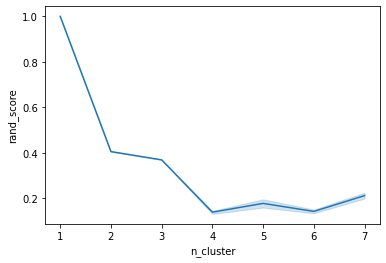

In [19]:
sns.lineplot(data=df_rand_scores_plot, x='n_cluster', y='rand_score', palette='bright')